# **Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti & Prof. Nicolò Navarin and Dr. Luca Pasa
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). 

#Requirements

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━

#Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing. 

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [3]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [4]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [6]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [7]:
# Set niose factor for later
noise_factor = 0.1

# [TO COMPLETE] SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [8]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

Now we create the dataset ready for the SVD:

In [9]:
device = torch.device("cpu") #for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [10]:
ENCODING_DIM =400  #[TO COMPLETE]

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [11]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [12]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00067
Test mse: 0.00070


In [13]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

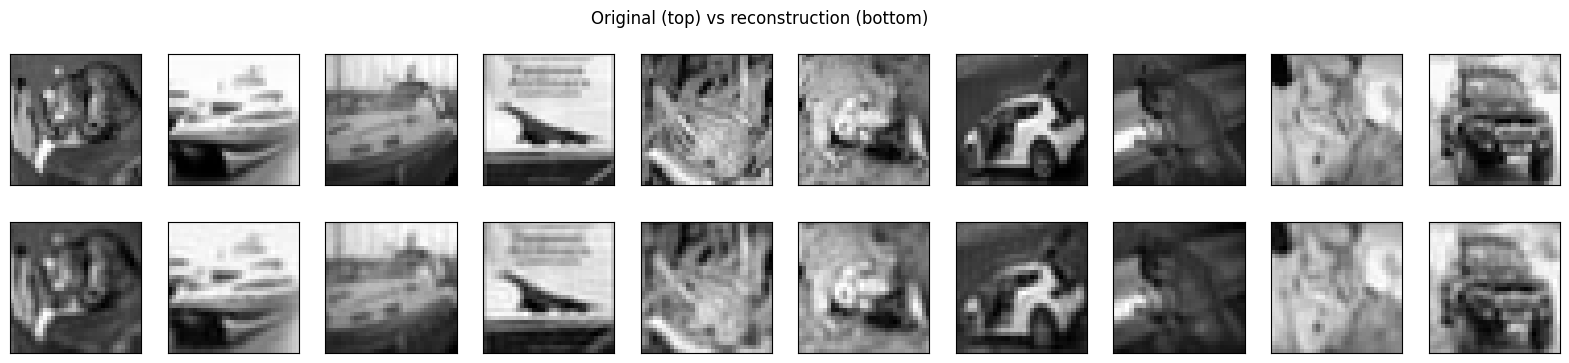

In [14]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")


**[TO COMPLETE]**: What happens by varying the ENCODING_DIM?
 Test and discuss the results in a cell below.

`%STARTEXT`

**ANSWER**:

The SVD factorization method is used to at the same time, reduce the number of input features or variables and preseriving the most important informations. So, lower values of ENCODING_DIM will result in greater compression and greater information loss, whereas larger values will result in less compression and greater information retention. In particular I've tried to use initially 250 and than the images resulted to lose many fine-grained details, and by computing the mean squared error between the original input and the reconstruction, I've gained a training mse=0.00155 and a test mse=0.00159. Then, I've changed the number of the size of the compressed version of input data to 400: the reconstructed images are so much similar to the original ones and training mse= 0.00067 and test mse=0.00070. 

`%ENDEXT`

# [TO COMPLETE] Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.1 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. The `forward` method defines the forward pass of the Autoencoder.

In [16]:
class Auto_Encoder(nn.Module):
  
  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))
    
      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer
    
    self.apply(self._init_weights)
    
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()
  
  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

**[TO COMPLETE]** Check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition. 

Try also to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [17]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'linear'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [19]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    
    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [20]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.84023720 ---------------- Val_Acc: Val_Loss: 0.24289370
epoch: 2 -> Loss: 0.18311557 ---------------- Val_Acc: Val_Loss: 0.14210072
epoch: 3 -> Loss: 0.13607724 ---------------- Val_Acc: Val_Loss: 0.09746448
epoch: 4 -> Loss: 0.08326592 ---------------- Val_Acc: Val_Loss: 0.07312182
epoch: 5 -> Loss: 0.06352931 ---------------- Val_Acc: Val_Loss: 0.05738745
epoch: 6 -> Loss: 0.05076410 ---------------- Val_Acc: Val_Loss: 0.04770574
epoch: 7 -> Loss: 0.04154631 ---------------- Val_Acc: Val_Loss: 0.03933067
epoch: 8 -> Loss: 0.03496047 ---------------- Val_Acc: Val_Loss: 0.03275707
epoch: 9 -> Loss: 0.02994352 ---------------- Val_Acc: Val_Loss: 0.02894221
epoch: 10 -> Loss: 0.02598772 ---------------- Val_Acc: Val_Loss: 0.02485842
epoch: 11 -> Loss: 0.02277599 ---------------- Val_Acc: Val_Loss: 0.02222632
epoch: 12 -> Loss: 0.02030892 ---------------- Val_Acc: Val_Loss: 0.01975124
epoch: 13 -> Loss: 0.01826003 ---------------- Val_Acc: Val_Loss: 0.01789361
epoch: 1

In [21]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

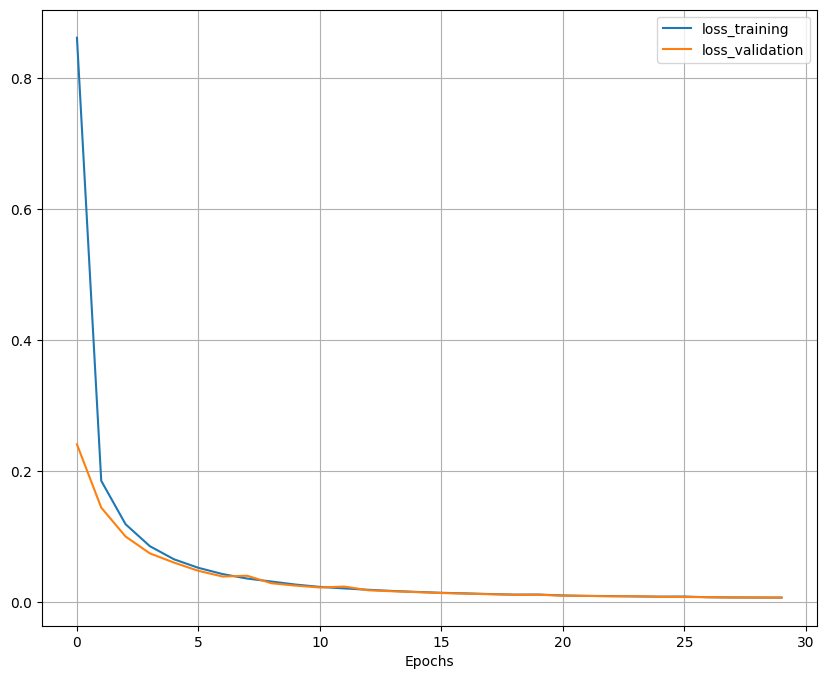

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [22]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [23]:
test(Shallow_AE)

Test Loss: 0.00664678


In [24]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [25]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

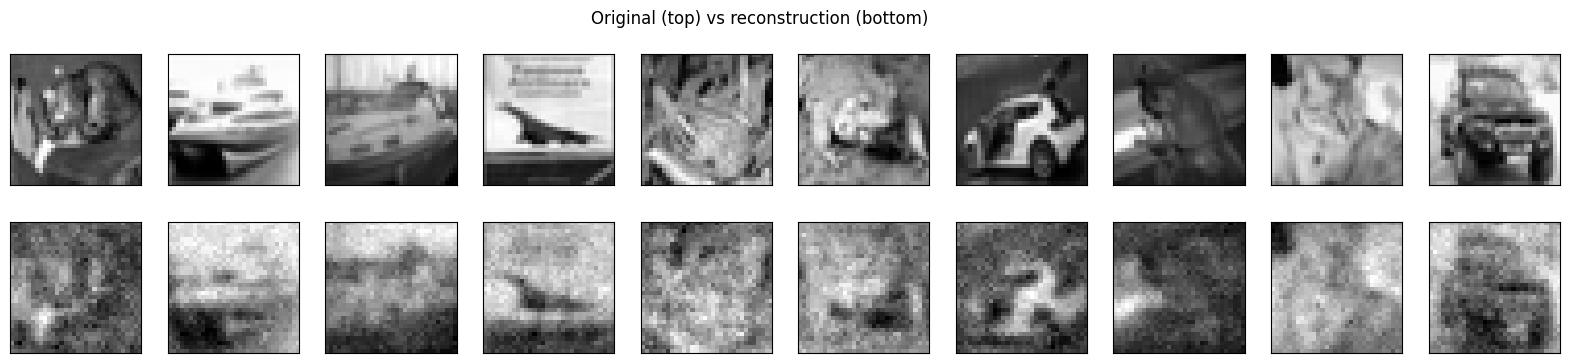

In [26]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder.)

`%STARTEXT`

**ANSWER**:
Appling the SVD decomposition I've the test mse=0.00070, instead  with the shallow linear the test loss results 0.00664678. So, it's possible to say that the SVD is able to keep a good capacity in reconstructing the input data. In fact, also the output images are better with the first method. I think that depends by the different approach of the two methods in reducing the input dimension: while the SVD uses a precise factorization of the initial matrix, in the shallow linear autoencoder method, the compression is done by training the model on a dataset of input samples, so it seeks to learn an approximation of the underlying structure through an iterative training procedure. 

`%ENDTEXT`

# [TO COMPLETE] Shallow non-linear Autoencoder

**[TO COMPLETE]** Replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 30 
# END

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04034512 ---------------- Val_Acc: Val_Loss: 0.02603671
epoch: 2 -> Loss: 0.02228362 ---------------- Val_Acc: Val_Loss: 0.01880799
epoch: 3 -> Loss: 0.01821579 ---------------- Val_Acc: Val_Loss: 0.01587777
epoch: 4 -> Loss: 0.01473839 ---------------- Val_Acc: Val_Loss: 0.01448419
epoch: 5 -> Loss: 0.01336567 ---------------- Val_Acc: Val_Loss: 0.01334202
epoch: 6 -> Loss: 0.01214458 ---------------- Val_Acc: Val_Loss: 0.01116181
epoch: 7 -> Loss: 0.01121078 ---------------- Val_Acc: Val_Loss: 0.01028619
epoch: 8 -> Loss: 0.01072067 ---------------- Val_Acc: Val_Loss: 0.00980080
epoch: 9 -> Loss: 0.01026144 ---------------- Val_Acc: Val_Loss: 0.00994480
epoch: 10 -> Loss: 0.00948107 ---------------- Val_Acc: Val_Loss: 0.00958650
epoch: 11 -> Loss: 0.00940456 ---------------- Val_Acc: Val_Loss: 0.00871414
epoch: 12 -> Loss: 0.00890866 ---------------- Val_Acc: Val_Loss: 0.00853766
epoch: 13 -> Loss: 0.00868848 ---------------- Val_Acc: Val_Loss: 0.00830261
epoch: 1

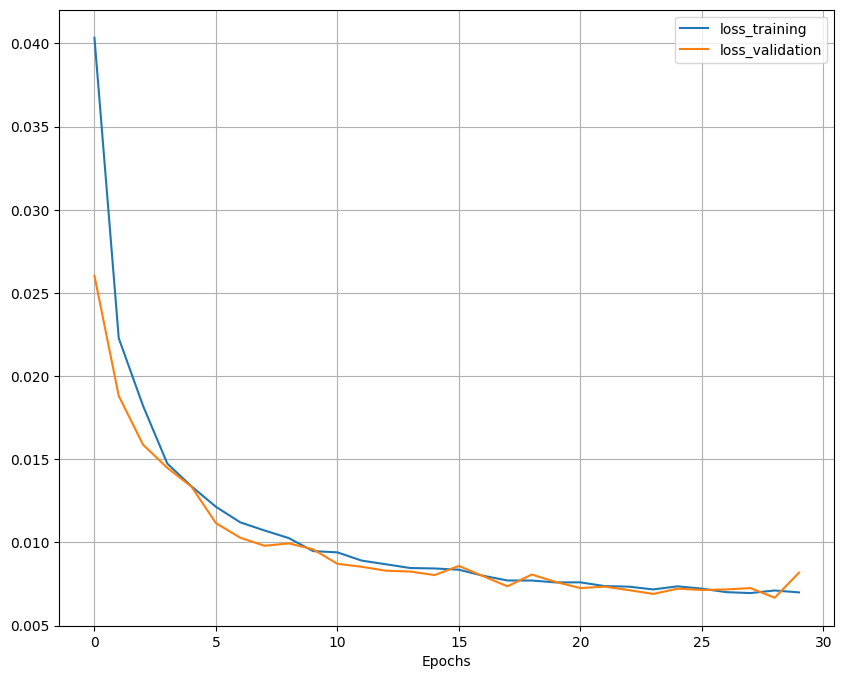

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(Shallow_non_AE)

Test Loss: 0.00823298


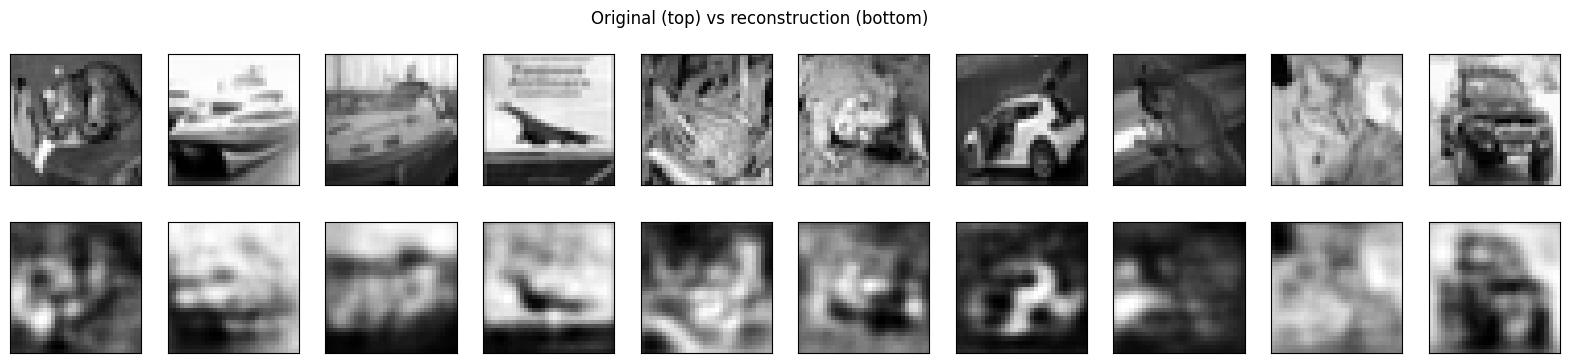

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Discuss the results you obtained with the activation functions you have tested and also motivate your choice. Compare your results to the ones obtained with the Shallow Linear Autoencoder.

`%STARTEXT`

**ANSWER**:

I've tested three different non-linear activation-function: the Sigmoid, the Relu and the Tanh. The sigmod compress the input data in the interval between 0 and 1 and its test loss is equal to  0.00823298. The Relu function returns the input value if it's positive, instead returns 0, this gave me the test loss equal to 0.02382173. Finally, the Tanh is symmetric about the origin, and returns values within the range -1 and 1, this returned a test loss of 0.01419227. So the function that works better on this data is the sigmoid one, in fact also the output reconstructed images are better. 

In terms of loss this result is similar to the one obtained with the linear Autoencoder. For which concerne the images in the linear method they're so pixeled, while in the non linear one they're blurry. In both cases it's not so clear what is represented. 

`%ENDTEXT`

# [TO COMPLETE] Deep Autoencoder

**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e., $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

`%STARTCODE`

In [53]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256,128,64] 
DEC_LAYERS = [128,256] 
ACT_FUN = 'leaky_relu'
lr = 0.0005
epochs = 30 
# END

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
│    └─Linear: 2-2                       [512, 128]                32,896
│    └─Linear: 2-3                       [512, 64]                 8,256
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 128]                8,320
│    └─Linear: 2-5                       [512, 256]                33,024
│    └─Linear: 2-6                       [512, 1024]               263,168
Total params: 608,064
Trainable params: 608,064
Non-trainable params: 0
Total mult-adds (M): 311.33
Input size (MB): 2.10
Forward/backward pass size (MB): 7.60
Params size (MB): 2.43
Estimated Total Size (MB): 12.13

In [54]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [55]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.05281245 ---------------- Val_Acc: Val_Loss: 0.04066611
epoch: 2 -> Loss: 0.03519586 ---------------- Val_Acc: Val_Loss: 0.03233865
epoch: 3 -> Loss: 0.02748217 ---------------- Val_Acc: Val_Loss: 0.02562888
epoch: 4 -> Loss: 0.02302257 ---------------- Val_Acc: Val_Loss: 0.02224531
epoch: 5 -> Loss: 0.02114394 ---------------- Val_Acc: Val_Loss: 0.02027728
epoch: 6 -> Loss: 0.01975803 ---------------- Val_Acc: Val_Loss: 0.01916174
epoch: 7 -> Loss: 0.01881510 ---------------- Val_Acc: Val_Loss: 0.01833723
epoch: 8 -> Loss: 0.01799686 ---------------- Val_Acc: Val_Loss: 0.01789842
epoch: 9 -> Loss: 0.01736714 ---------------- Val_Acc: Val_Loss: 0.01712948
epoch: 10 -> Loss: 0.01694547 ---------------- Val_Acc: Val_Loss: 0.01768254
epoch: 11 -> Loss: 0.01656575 ---------------- Val_Acc: Val_Loss: 0.01643392
epoch: 12 -> Loss: 0.01623410 ---------------- Val_Acc: Val_Loss: 0.01603524
epoch: 13 -> Loss: 0.01598096 ---------------- Val_Acc: Val_Loss: 0.01577767
epoch: 1

KeyboardInterrupt: ignored

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(DEEP_non_AE)

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Write a short report of the results you obtained trying different hyperparameters configurations.

`%STARTEXT`

**ANSWER**:
First of all I've tried these parameters:

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [100,50,25] 
DEC_LAYERS = [25,100]    
ACT_FUN = 'relu'
lr = 0.001
epochs = 30 

I've gained a test loss=0.01682947, so I've tried to increase the dimension of the encoder layers:

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256,128,64] 
DEC_LAYERS = [128,256] 
ACT_FUN = 'relu'
lr = 0.001
epochs = 30 

with this new model, the loss was equal to 0.013 and images were a little bit better. 
Just beacuse the ReLU activation function could have some problems on the deep autoencoders where some neurons may become inactive and produce zero outputs, I've decide to change the activation function of this last model with Leaky ReLU. 

Finally, I've tried to decrease the learning rate, obtaining this model:

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256,128,64] 
DEC_LAYERS = [128,256] 
ACT_FUN = 'leaky_relu'
lr = 0.0005
epochs = 30 

Now the test loss is 0.01284852, even if the images are not so good as expected.

`%ENDTEXT`

# [TO COMPLETE] Shallow Denoising Autoencoder

**[TO COMPLETE]** Let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$. Write a short report of your findings below.

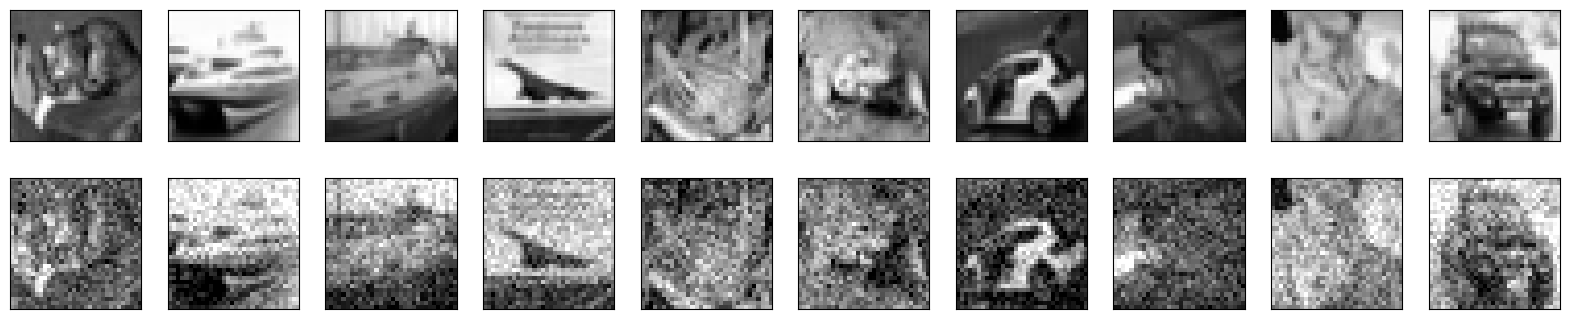

In [43]:
plot_img(10, [x_test, x_test_noisy])

`%STARTCODE`

In [44]:
# [TO COMPLETE]
# define model and training hyperparameters
noise_factor = 0.3
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 30 

# END

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 512]                524,800
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               525,312
Total params: 1,050,112
Trainable params: 1,050,112
Non-trainable params: 0
Total mult-adds (M): 537.66
Input size (MB): 2.10
Forward/backward pass size (MB): 6.29
Params size (MB): 4.20
Estimated Total Size (MB): 12.59

In [45]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [46]:
start = timer()

# [TO COMPLETE]
# call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True)#[TO COMPLETE]

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.04172306 ---------------- Val_Acc: Val_Loss: 0.02771380
epoch: 2 -> Loss: 0.02185021 ---------------- Val_Acc: Val_Loss: 0.01883296
epoch: 3 -> Loss: 0.01631509 ---------------- Val_Acc: Val_Loss: 0.01450609
epoch: 4 -> Loss: 0.01550825 ---------------- Val_Acc: Val_Loss: 0.01296085
epoch: 5 -> Loss: 0.01261848 ---------------- Val_Acc: Val_Loss: 0.02026926
epoch: 6 -> Loss: 0.01172546 ---------------- Val_Acc: Val_Loss: 0.01100617
epoch: 7 -> Loss: 0.01099963 ---------------- Val_Acc: Val_Loss: 0.01009704
epoch: 8 -> Loss: 0.01033733 ---------------- Val_Acc: Val_Loss: 0.00963424
epoch: 9 -> Loss: 0.00971757 ---------------- Val_Acc: Val_Loss: 0.01238514
epoch: 10 -> Loss: 0.00949709 ---------------- Val_Acc: Val_Loss: 0.00941816
epoch: 11 -> Loss: 0.00904203 ---------------- Val_Acc: Val_Loss: 0.00881666
epoch: 12 -> Loss: 0.00874870 ---------------- Val_Acc: Val_Loss: 0.00965052
epoch: 13 -> Loss: 0.00860138 ---------------- Val_Acc: Val_Loss: 0.00809180
epoch: 1

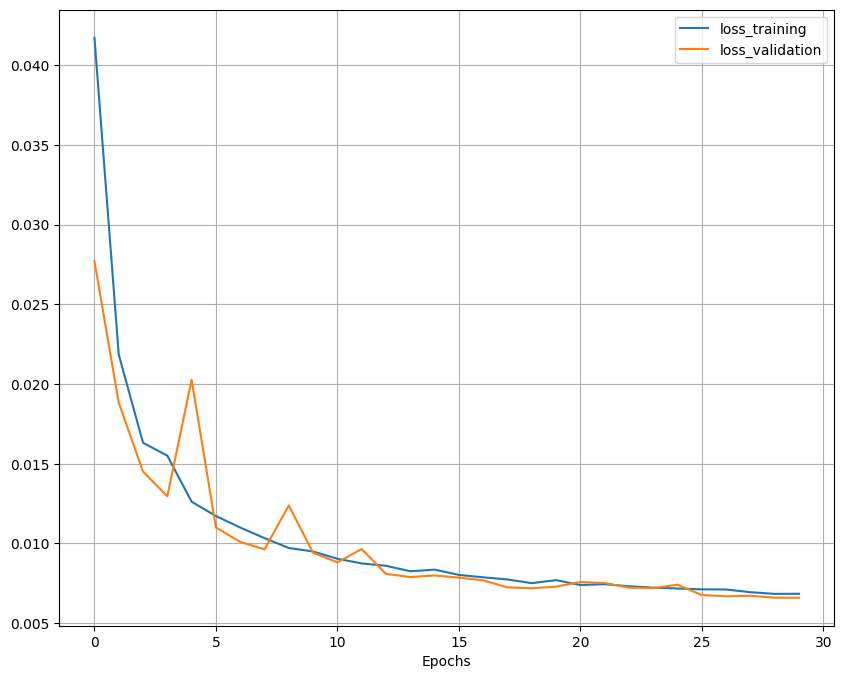

In [47]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [48]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00658789


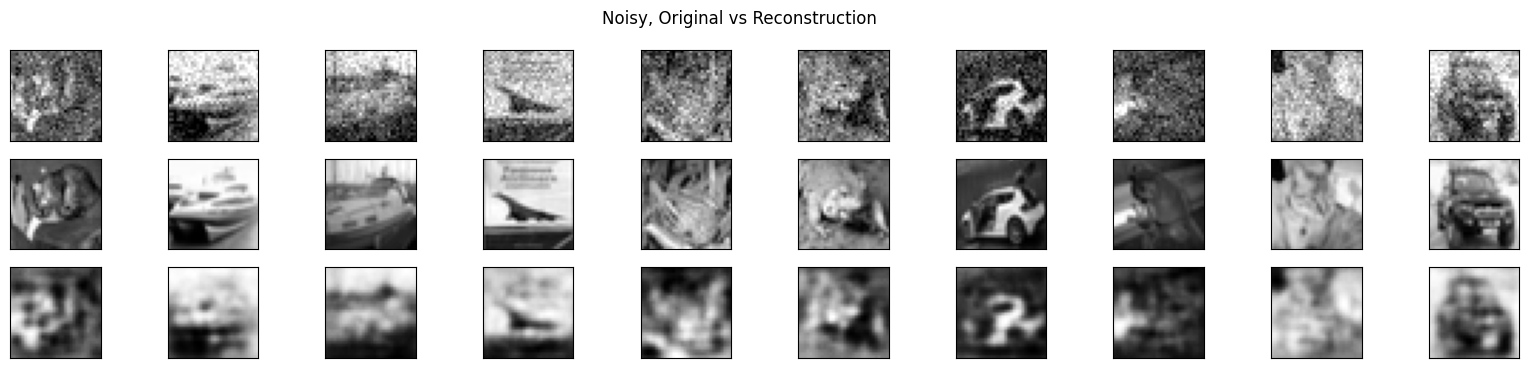

In [49]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

`%ENDCODE`

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

`%STARTEXT`

**ANSWER**:

I've tried, as first, this model:

noise_factor = 0.1
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'leaky_relu'
lr = 0.005
epochs = 30 

This has gave a test loss equal to 0.00981821. Tring to reduce it I've tried the same but with an increasing in the dimension of the encoder level:

noise_factor = 0.1
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512] 
DEC_LAYERS = [] 
ACT_FUN = 'leaky_relu'
lr = 0.005
epochs = 30 

The test loss has decreased to 0.00852295 and also immages were better.
I've tried to improve this same model changing the activation function in the sigmoid one, and turning back to the same number of levels as before:

noise_factor = 0.1
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 30 

Indeed the test Loss has reached the value 0.00806740. 
Finally, in order to test the impact of the noise factor on the model's denoising capability, I've tried the same ones but with noise factor=0.3. First:

noise_factor = 0.3
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'leaky_relu'
lr = 0.005
epochs = 30 

Now, the test loss was equal to 0.00976783, it is improved, but in my opinion, the impact is not so strong, Then: 

noise_factor = 0.3
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512] 
DEC_LAYERS = [] 
ACT_FUN = 'leaky_relu'
lr = 0.005
epochs = 30 

The test loss=0.00856332, in this case is also a little bit worst than the one obtained with a minor noise factor and reconstructed images distorted. 
The last one:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 30 

Finally I've had the best test loss reached (=0.00658789) and also better images, thanks to the impact of the noise factor. 

`%ENDTEXT`